In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import feedparser as fp
import prophet as pr
from sklearn.preprocessing import MinMaxScaler


In [32]:
DATAPATH = './data'
STOCKSPATH = os.path.join(DATAPATH, 'stocks')
METADATA = os.path.join(DATAPATH, 'symbols_valid_meta.csv')

In [33]:
# Load the metadata
metadata = pd.read_csv(METADATA)

In [34]:
metadata.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [35]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB


In [36]:
metadata.shape

(8049, 12)

In [37]:
# Check for null values
metadata.isnull().sum()

Nasdaq Traded          0
Symbol                 0
Security Name          0
Listing Exchange       0
Market Category        0
ETF                    0
Round Lot Size         0
Test Issue             0
Financial Status    4666
CQS Symbol          3383
NASDAQ Symbol          0
NextShares             0
dtype: int64

Here, I can spot a coule of null values for the field 'Financial Status' and 'CQS Symbol'. Not sure what to do with them yet.

In [49]:
# Loading the stock data for a random company
stock_APPL = pd.read_csv(os.path.join(STOCKSPATH, 'AAPL.csv'))

In [50]:
stock_APPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [51]:
stock_APPL.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500
9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,240.910004,43956200


There seems to be 5884 files in the stock directory.
Is there a way to find out the agerage max and min dates for all stock companies?

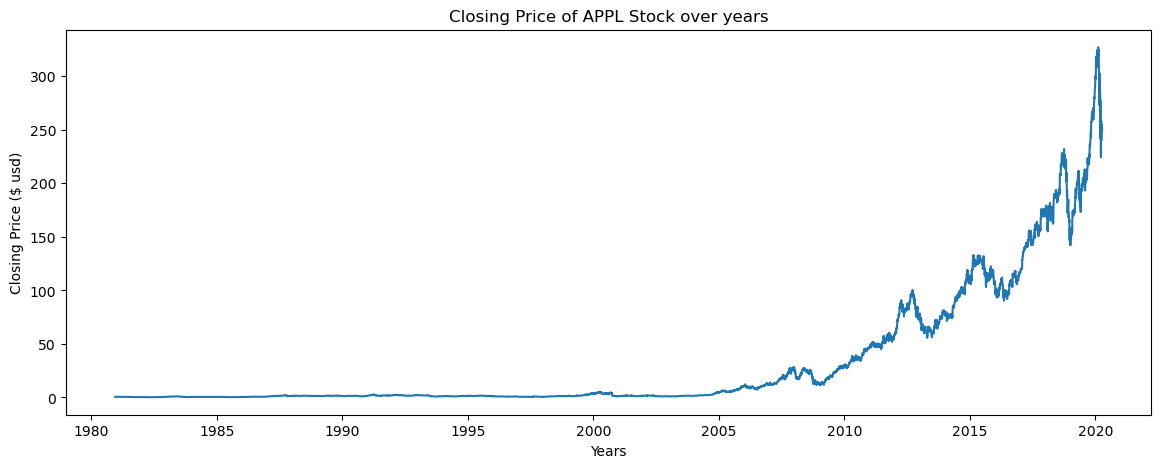

In [52]:
# Plot the closing price of the APPL stock over years
stock_APPL['Date'] = pd.to_datetime(stock_APPL['Date'])

plt.figure(figsize=(14, 5))
plt.plot(stock_APPL['Date'], stock_APPL['Close'])
plt.xlabel('Years')
plt.ylabel('Closing Price ($ usd)')
plt.title('Closing Price of APPL Stock over years')
plt.show()


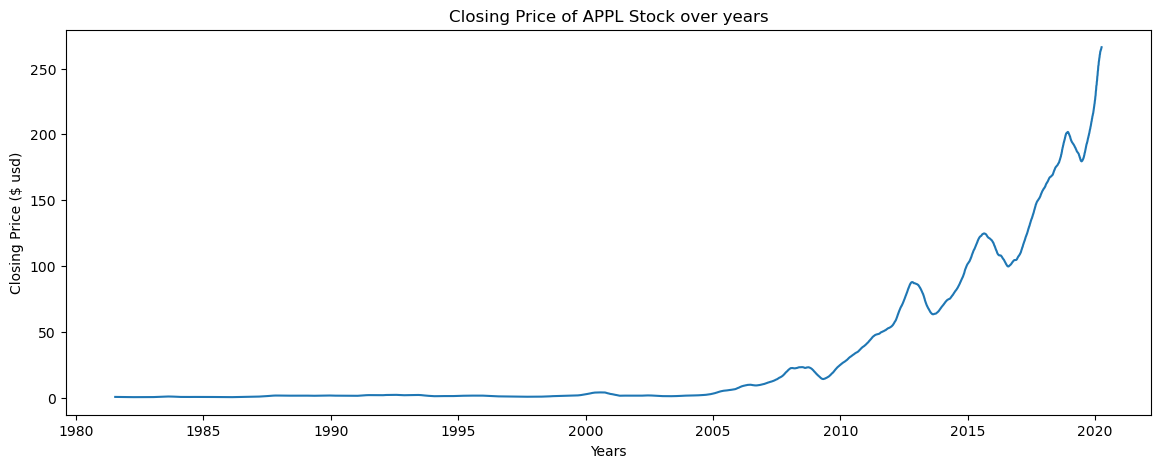

In [53]:
# Plot the closing price of the APPL stock over years
stock_APPL['Date'] = pd.to_datetime(stock_APPL['Date'])
stock_APPL['Close'] = stock_APPL['Close'].rolling(150).mean()

plt.figure(figsize=(14, 5))
plt.plot(stock_APPL['Date'], stock_APPL['Close'])
plt.xlabel('Years')
plt.ylabel('Closing Price ($ usd)')
plt.title('Closing Price of APPL Stock over years')
plt.show()

In [54]:
stock_APPL.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close        149
Adj Close      0
Volume         0
dtype: int64

In [55]:
stock_APPL.dropna(inplace=True)
stock_APPL.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [43]:
# rss_url = 'https://www.ft.com/business-education?format=rss'
# feed = fp.parse(rss_url)

In [44]:
# # Print all feed entries
# for entry in feed.entries:
#     print(entry.title)

In [56]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply min-max scaling on the 'Close' column of the stock_APPL dataframe
stock_APPL['Close'] = scaler.fit_transform(stock_APPL[['Close']])

## Trying out the prophet model

In [57]:
stock_APPL_new = stock_APPL[['Date', 'Close']]

# Selecting the max cap to be 30% more than the max value of the closing price
stock_APPL_new['cap'] = max(stock_APPL_new['Close']) * 1.3

# Renaming the columns as required by the prophet model
stock_APPL_new = stock_APPL_new.rename(columns={'Date': 'ds', 'Close': 'y'})

/var/folders/g3/bvc41fqj3v70mtgzjrxyv6b00000gn/T/ipykernel_16889/869839118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_APPL_new['cap'] = max(stock_APPL_new['Close']) * 1.3


In [58]:
stock_APPL_new.head()

,ds,y,cap
149,1981-07-17,0.000873,1.3
150,1981-07-20,0.000870,1.3
151,1981-07-21,0.000869,1.3
152,1981-07-22,0.000868,1.3
153,1981-07-23,0.000867,1.3


In [59]:
prophet_model = pr.Prophet(growth='logistic')
prophet_model.fit(stock_APPL_new)

23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing


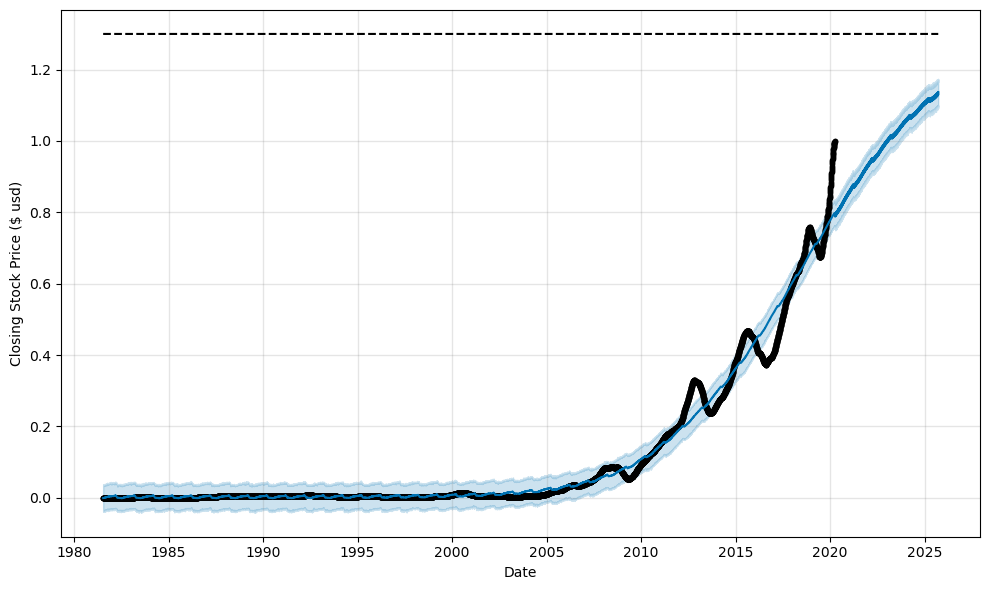

In [60]:
future = prophet_model.make_future_dataframe(periods=2000)
future['cap'] = max(stock_APPL['Close']) * 1.3
forecast = prophet_model.predict(future)
fig = prophet_model.plot(forecast, xlabel='Date', ylabel='Closing Stock Price ($ usd)')

Here, we can see that the model is able to predict some values. Let's see if we are able to do some predictions.

In [66]:
def predict_for_date(date, model):
    future_date = pd.DataFrame({'ds': [date]})
    future_date['cap'] = max(stock_APPL['Close']) * 1.3
    forecast = model.predict(future_date)
    forecast = scaler.inverse_transform(forecast[['yhat']])
    return forecast[0][0]

In [67]:
# Predicting the closing price for the next 10 days starting from today
for i in range(1, 11):
    date = pd.to_datetime('today') + pd.to_timedelta(i, unit='d')
    print('The closing price for APPL on {} is predicted to be ${:.2f}'.format(date.date(), predict_for_date(date, prophet_model)))


The closing price for APPL on 2023-11-22 is predicted to be $280.55
The closing price for APPL on 2023-11-23 is predicted to be $280.64
The closing price for APPL on 2023-11-24 is predicted to be $278.58
The closing price for APPL on 2023-11-25 is predicted to be $278.53
The closing price for APPL on 2023-11-26 is predicted to be $280.74
The closing price for APPL on 2023-11-27 is predicted to be $280.74
The closing price for APPL on 2023-11-28 is predicted to be $280.81
The closing price for APPL on 2023-11-29 is predicted to be $280.87
The closing price for APPL on 2023-11-30 is predicted to be $280.95
The closing price for APPL on 2023-12-01 is predicted to be $278.88


  0%|          | 0/73 [00:00<?, ?it/s]23:30:15 - cmdstanpy - INFO - Chain [1] start processing
23:30:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/anshulshandilya/miniconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:1346: RuntimeWarning: overflow encountered in exp
  return cap / (1 + np.exp(-k_t * (t - m_t)))
/Users/anshulshandilya/miniconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:1346: RuntimeWarning: overflow encountered in exp
  return cap / (1 + np.exp(-k_t * (t - m_t)))
/Users/anshulshandilya/miniconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:1789: RuntimeWarning: overflow encountered in exp
  sample_trends = cap / (1 + np.exp(-k_t * (t_time - m_t)))
  1%|▏         | 1/73 [00:00<00:15,  4.70it/s]23:30:15 - cmdstanpy - INFO - Chain [1] start processing
23:30:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/anshulshandilya/miniconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.000842  0.029012  0.014696  0.414959  0.293545  0.480365   
1 38 days  0.000848  0.029121  0.014745  0.417591  0.294098  0.482000   
2 39 days  0.000862  0.029366  0.014836  0.419511  0.293545  0.482865   
3 40 days  0.000875  0.029578  0.014895  0.420689  0.295138  0.483368   
4 41 days  0.000872  0.029534  0.014829  0.421117  0.294744  0.483515   

   coverage  
0  0.461066  
1  0.461711  
2  0.462363  
3  0.462609  
4  0.464080  


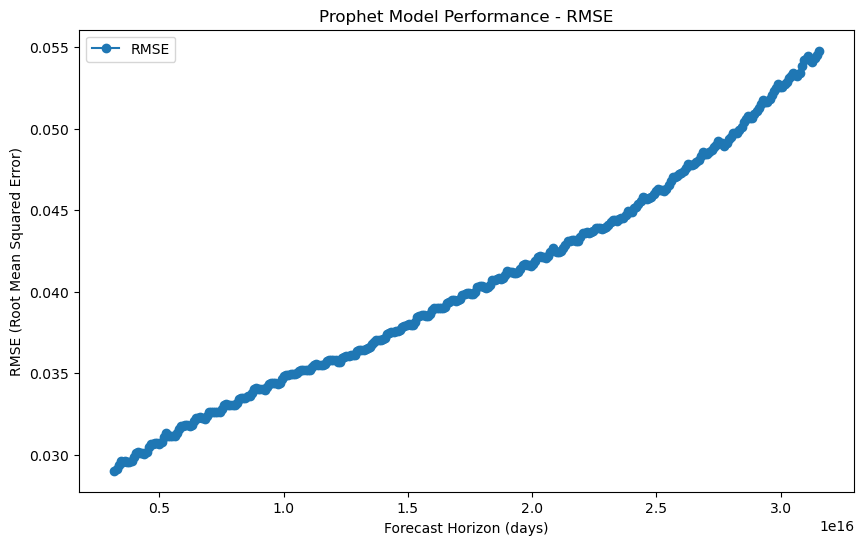

In [68]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation to get performance metrics
df_cv = cross_validation(prophet_model, initial='730 days', period='180 days', horizon='365 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)

# Print the metrics
print(df_p.head())

# Plot the RMSE
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_p['horizon'], df_p['rmse'], label='RMSE', marker='o')
ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('RMSE (Root Mean Squared Error)')
ax.set_title('Prophet Model Performance - RMSE')
ax.legend()
plt.show()

In [69]:
# stock_APPL.head()

In [70]:
# # Change all column headings to be lower case, and remove spacing
# stock_APPL.columns = [str(x).lower().replace(' ', '_') for x in stock_APPL.columns]

# # Sort by datetime
# stock_APPL.sort_values(by='date', inplace=True, ascending=True)

# stock_APPL.head()

In [71]:
# stock_APPL.tail()

In [72]:
# # Get the max and min date from the stock data
# min_date = min( stock_APPL['date'])
# max_date = max(stock_APPL['date'])

# print('Min Date: {}'.format(min_date))
# print('Max Date: {}'.format(max_date))

In [73]:
# # Set the figure size for this specific plot
# fig, ax = plt.subplots(figsize=(10, 8))

# # Plot adjusted close over time
# ax.plot(stock_APPL['date'], stock_APPL['adj_close'], 'b-', label='Adjusted Close')
# ax.set_xlabel("Date")
# ax.set_ylabel("USD")
# ax.grid(True)
# ax.legend()

# # Show the plot
# plt.show()
